In [129]:
import numpy as np
import scipy
from activ import load_data
from activ.readfile import load_preprocessed, TrackTBIFile, encode
from activ.data_normalization import data_normalization
import pandas as pd
from sklearn import preprocessing
from collections import Counter
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import pandas as pd
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl
import os
from activ.analytics import conf_alliter, accuracy, plot_clustering_results_activ_data
from scipy.optimize import curve_fit

In [141]:
bm_5, y_5 = make_blobs(n_samples=247, centers=5, n_features=235, random_state=0)
bm_10, y_10 = make_blobs(n_samples=247, centers=10, n_features=235, random_state=0)
bm_15, y_15 = make_blobs(n_samples=247, centers=15, n_features=235, random_state=0)
bm_20, y_20 = make_blobs(n_samples=247, centers=20, n_features=235, random_state=0)
bm_25, y_25 = make_blobs(n_samples=247, centers=25, n_features=235, random_state=0)
bm_30, y_30 = make_blobs(n_samples=247, centers=30, n_features=235, random_state=0)


In [142]:
transform_matrix = np.random.normal(size=(235,177))
error = np.random.normal(size=(247,177))

In [143]:
oc_5 = bm_5 @ transform_matrix + error
oc_10 = bm_10 @ transform_matrix + error
oc_15 = bm_15 @ transform_matrix + error
oc_20 = bm_20 @ transform_matrix + error
oc_25 = bm_25 @ transform_matrix + error
oc_30 = bm_30 @ transform_matrix + error 

In [144]:
TrackTBIFile.write('/Users/ahyeon/data/activ/sim5_data.h5', bm_5, oc_5)
TrackTBIFile.write('/Users/ahyeon/data/activ/sim10_data.h5', bm_10, oc_10)
TrackTBIFile.write('/Users/ahyeon/data/activ/sim15_data.h5', bm_15, oc_15)
TrackTBIFile.write('/Users/ahyeon/data/activ/sim20_data.h5', bm_20, oc_20)
TrackTBIFile.write('/Users/ahyeon/data/activ/sim25_data.h5', bm_25, oc_25)
TrackTBIFile.write('/Users/ahyeon/data/activ/sim30_data.h5', bm_30, oc_30)

/Users/ahyeon/Desktop/activ/activ/analytics.py:279: RuntimeWarning: divide by zero encountered in double_scalars
  foc = [float(x/y) for x, y in zip(acc, norm_acc)]


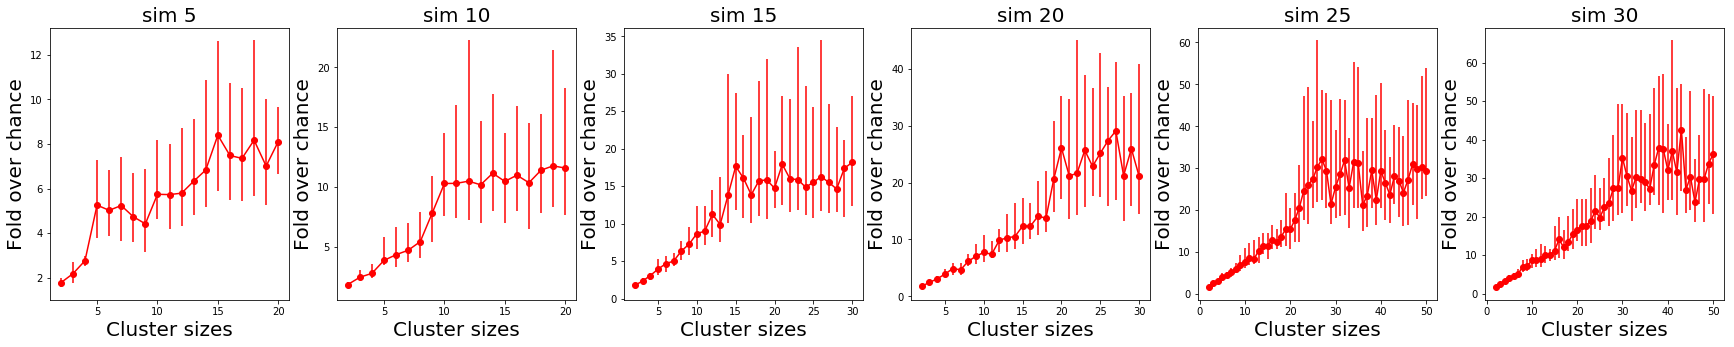

In [4]:
num = [5,10,15,20,25,30]
fig1 = plt.figure(figsize=(30,5))
for j,n in zip(range(6), num):
    fig1.add_subplot(1, 6, j+1)
    plot_clustering_results_activ_data('simdata/sim_{}'.format(n), 'foc', specific_plot_name='sim {}'.format(n))
plt.savefig('/Users/ahyeon/Desktop/activ misc/fig1.png')
plt.show()

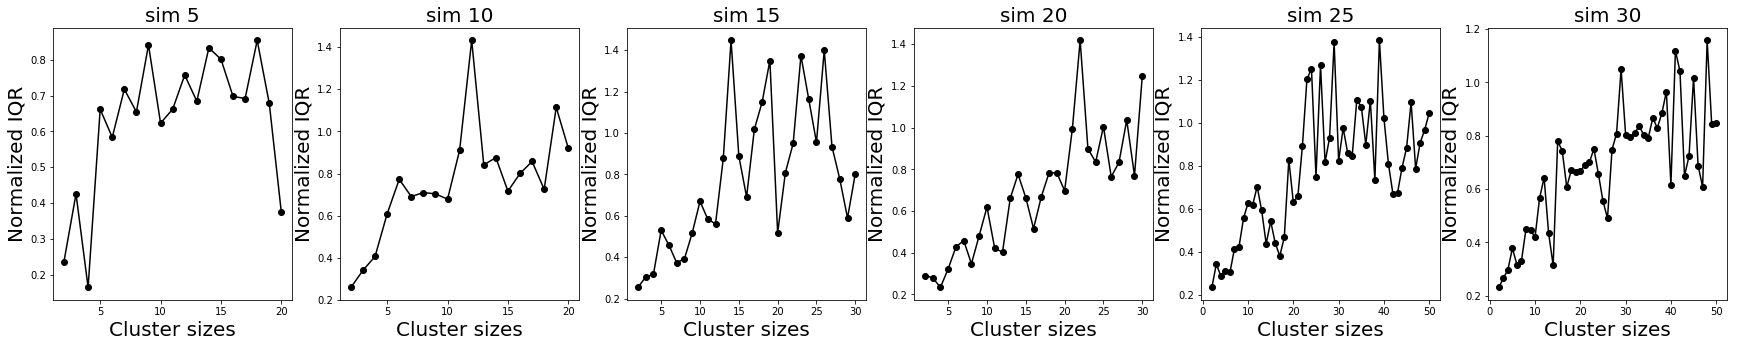

In [5]:
fig2 = plt.figure(figsize=(30,5))
for j,n in zip(range(6), num):
    fig2.add_subplot(1, 6, j+1)
    plot_clustering_results_activ_data('simdata/sim_{}'.format(n), 'iqr', specific_plot_name='sim {}'.format(n))
plt.savefig('/Users/ahyeon/Desktop/activ misc/fig2.png')
plt.show()

In [6]:
import PIL
list_im = ['/Users/ahyeon/Desktop/activ misc/fig1.png', '/Users/ahyeon/Desktop/activ misc/fig2.png']
imgs    = [ PIL.Image.open(i) for i in list_im ]
imgs_comb = np.vstack(i for i in imgs) 
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb

def func(x, a, b, c):
    return (a * np.exp(-b * x)) + imgs_comb.save('/Users/ahyeon/Desktop/activ misc/sim_foc_iqr.png', bbox_inches='tight')

In [99]:
def func(x, a, b, c):
    return (a * np.exp(-b * x)) + c

def plot_optimal_k(data, name):
    yvar = np.var(data, axis=1)
    ydata = np.mean(data, axis=1)
    popt, pcov = curve_fit(func, cluster_sizes, ydata, p0 = [1000,1,3])
    yval = func(cluster_sizes, *popt) 
    y = ydata
    plt.figure(figsize=(10,10))
    plt.plot(cluster_sizes, ydata, label='data', color='black')
    plt.plot(cluster_sizes, yval, '--',label='fit', color='red')
    plt.plot(cluster_sizes, [popt[2]]*len(cluster_sizes), '--', color='grey', label='asymptote')

    shift = 1.96*np.sqrt(yvar)
    grey_shift = 1.96*np.sqrt(pcov[2][2])
    optimal_k = np.where([popt[2]]*len(cluster_sizes)-grey_shift-(y+shift) <0)[0][0]+2
    plt.axvline(optimal_k, label='optimal k')
    plt.fill_between(cluster_sizes, y+shift, y-shift, alpha = 0.2, color='pink')
    plt.fill_between(cluster_sizes, [popt[2]]*len(cluster_sizes)+grey_shift, [popt[2]]*len(cluster_sizes)-grey_shift, alpha = 0.2, color='grey')

    plt.xlabel('Cluster Number', fontsize=16)
    plt.ylabel('Fold over Chance', fontsize=16)
    plt.title('{} vs Cluster Number\nk={}'.format(name, optimal_k), fontsize=20)
    plt.legend()

In [4]:
def conf_alliter(size, predicted, actual, iterations):
    confalliter = []
    for j in range(iterations):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

def accuracy(mat):
    return mat.trace()/mat.sum()

In [125]:
file = '/Users/ahyeon/Desktop/activ_misc/sim30_results.h5'
with h5py.File(file,'r') as f:
    predictions = np.squeeze(f['score'][:], axis=1)
    print(predictions.shape)
    norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
    cluster_sizes = f['cluster_sizes'][:]
    labels = np.squeeze(f['clusters'][:], axis=1)
    num_iter = predictions.shape[0]
    num_clust = len(cluster_sizes)
    fold_over_chance = np.zeros((num_clust, num_iter))
    raw_acc = np.zeros((num_clust, num_iter))
    normalized_acc = np.zeros((num_clust, num_iter))
    for jj,c in enumerate(cluster_sizes):
        all50mat = conf_alliter(c, predictions, labels, num_iter)
        norm_all50mat = conf_alliter(c, norm_predictions, labels, num_iter)
        acc = [accuracy(i) for i in all50mat]
        norm_acc = [accuracy(i) for i in norm_all50mat]
        foc = [float(x/y) for x, y in zip(acc, norm_acc)]
        fold_over_chance[jj,:] = foc
        raw_acc[jj,:] = acc
        normalized_acc[jj,:] = norm_acc

(50, 49, 247)


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


In [126]:
from numpy import inf
fold_over_chance[fold_over_chance == inf] = 0

In [127]:
np.mean(fold_over_chance, axis=1)

array([ 1.88346396,  2.68020825,  3.38399556,  4.38947331,  5.17592924,
        5.65393675,  7.55933348,  7.91889315,  9.19488641,  9.62211862,
       11.2288074 , 12.5474671 , 11.31201233, 13.41519735, 17.66937266,
       14.91249613, 17.12069324, 19.51332998, 20.14754746, 21.10871928,
       22.85536483, 22.21146186, 25.89756327, 24.74999639, 26.39397462,
       34.31761168, 42.51592171, 41.43481414, 42.46649357, 38.31793566,
       35.83599479, 39.97573924, 42.12450581, 44.99479874, 38.41165453,
       44.69088832, 53.04845665, 51.39610055, 45.33241164, 43.63079509,
       37.76589921, 49.44143151, 35.9959757 , 38.21279205, 34.99558519,
       36.27506113, 51.3178079 , 47.4442361 , 53.88567621])

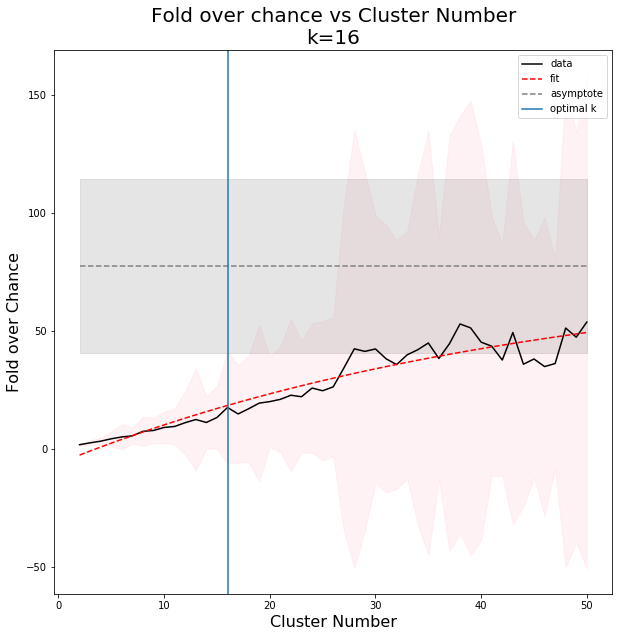

In [128]:
plot_optimal_k(fold_over_chance, 'Fold over chance')

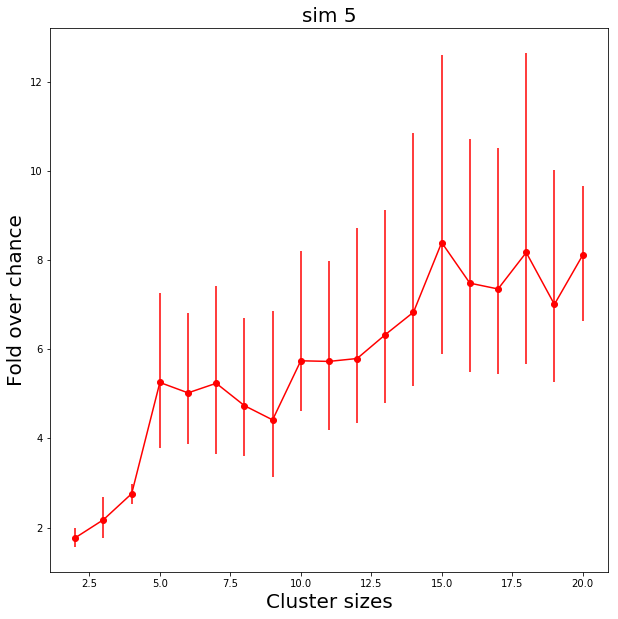

In [2]:
plot_clustering_results_activ_data('simdata/sim_{}'.format(5), 'foc', specific_plot_name='sim {}'.format(5))
